In [33]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# Fetch Unemployment data using BLS Public Data API

In [34]:
# Import or assign API key
ak = "64ff04ec58d44dd1ab4427731c684fc2"

In [35]:
headers = {'Content-type': 'application/json'}

unemploy = pd.DataFrame()

# Fetch the 1st 20years of data
unemploy01 = json.dumps({"seriesid": ['LNS14000000'], "startyear": "1999", "endyear": "2019","registrationkey":ak})
p1 = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=unemploy01, headers=headers)
json_unemploy01 = json.loads(p1.text)

# Fetch the last 5years of data
unemploy02 = json.dumps({"seriesid": ['LNS14000000'], "startyear": "2020", "endyear": "2024","registrationkey":ak})
p2 = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=unemploy02, headers=headers)
json_unemploy02 = json.loads(p2.text)

unemploy_list = [json_unemploy01, json_unemploy02]

for json_data in unemploy_list:
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        rows = []
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes = ""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
            if 'M01' <= period <= 'M12':
                rows.append([seriesId, year, period, value, footnotes[0:-1]])
        unemploy_part = pd.DataFrame(rows, columns=["series id", "year", "period", "value", "footnotes"])
        unemploy = pd.concat([unemploy, unemploy_part]).drop(columns=["series id", "footnotes"])

In [36]:
unemploy['period'] = unemploy['period'].map({'M01':'01', 'M02':'02', 'M03':'03', 'M04':'04', 'M05':'05', 'M06':'06', 'M07':'07', 'M08':'08', 'M09':'09',
       'M10':'10', 'M11':'11', 'M12':'12'})

In [37]:
unemploy['date'] = pd.to_datetime(unemploy['year'].astype(str) + unemploy['period'] + '01', format='%Y%m%d')
unemploy['UNEMPLOYMENT RATE'] = unemploy['value'].astype(float)
unemploy = unemploy.drop(columns=["period","value","year"],axis=1)
unemploy = unemploy.drop_duplicates(subset=['date'], keep="last").reset_index(drop=True)

In [38]:
unemploy.isnull().any()

date                 False
UNEMPLOYMENT RATE    False
dtype: bool

In [39]:
df_unemp = unemploy.set_index("date")
df_unemp.sort_values(by='date',inplace=True)
df_unemp.head()

,UNEMPLOYMENT RATE
date,
1999-01-01,4.3
1999-02-01,4.4
1999-03-01,4.2
1999-04-01,4.3
1999-05-01,4.2


# Exponential Smoothing

In [40]:
# Import packages
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px

In [41]:
def hyperparameter_tuning_season_cv(n_splits: int,var,
                                    gammas: list[float],
                                    df: pd.DataFrame) -> pd.DataFrame:
    """Function to carry out cross-validation hyperparameter tuning
    for the seasonal parameter in a Holt Winters' model. """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    error_list = []
    forecast_list = []
    gamma_list  = []

    for gamma in gammas:

        errors = []

        for train_index, valid_index in tscv.split(df):
            train, valid = df.iloc[train_index], df.iloc[valid_index]

            model = ExponentialSmoothing(train[var], trend='mul',
                                         seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=gamma)

            forecasts = model.forecast(len(valid))
            errors.append(mean_absolute_percentage_error(valid[var], forecasts))

        error_list.append([gamma, sum(errors) / len(errors)])
        forecast_list.append(forecasts) #added
        gamma_list.append(gamma) #added

    return pd.DataFrame(error_list, columns=['Gamma', 'MAPE'])


def plot_error_cv(df: pd.DataFrame,title: str) -> None:
    """Bar chart to plot the errors from the different
    hyperparameters."""

    fig = px.bar(df, x='Gamma', y='MAPE')
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=800, title_x=0.5, height=400)
    df_smooth = df[df.MAPE==df.MAPE.min()]
    smooth_factor = df_smooth.Gamma
    print('Smoothing Factor: ',smooth_factor)

    return fig.show(),smooth_factor

#Predict Unemployment Rate

In [42]:
# Carry out cv for hyperparameter tuning for the seasonal parameter
error_df = hyperparameter_tuning_season_cv(df=df_unemp,n_splits=4,var='UNEMPLOYMENT RATE',gammas=list(np.arange(0, 1.1, 0.1)))

# Plot the tuning results to view the best smoothing constant
plot,smooth = plot_error_cv(df=error_df, title='Hyperparameter Results')

#Build an Exponential model with the best smoothing constant (0.5)
model2 = ExponentialSmoothing(df_unemp['UNEMPLOYMENT RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)

Smoothing Factor:  10    1.0
Name: Gamma, dtype: float64


In [43]:
  # Split train and test
train = df_unemp.iloc[:-12]
print('Train size: ', len(train))
test = df_unemp.iloc[-12:]
print('Test size: ',len(test))

Train size:  280
Test size:  12


In [44]:
col = ['UNEMPLOYMENT RATE']
model = ExponentialSmoothing(train['UNEMPLOYMENT RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)
predictions = model.forecast(steps=len(test))
pred =  pd.DataFrame(predictions).set_index(test.index)
pred.columns = col
residuals = test['UNEMPLOYMENT RATE'] - pred['UNEMPLOYMENT RATE']
print(pred)

            UNEMPLOYMENT RATE
date                         
2023-05-01           4.408522
2023-06-01           8.232277
2023-07-01           2.753197
2023-08-01           2.347029
2023-09-01           2.704951
2023-10-01           1.933206
2023-11-01           2.329680
2023-12-01           1.987481
2024-01-01           2.430438
2024-02-01           2.904594
2024-03-01           2.243732
2024-04-01           2.415034


Text(0, 0.5, 'Error')

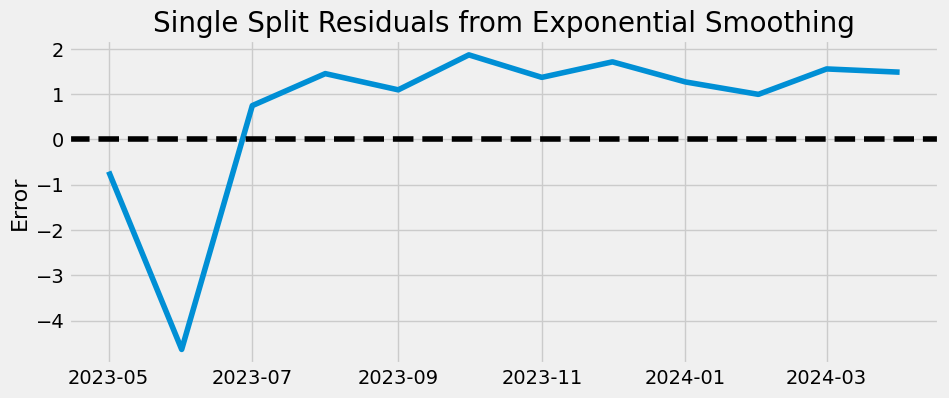

In [45]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Single Split Residuals from Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0.5, 1.0, 'UNEMPLOYMENT RATE')

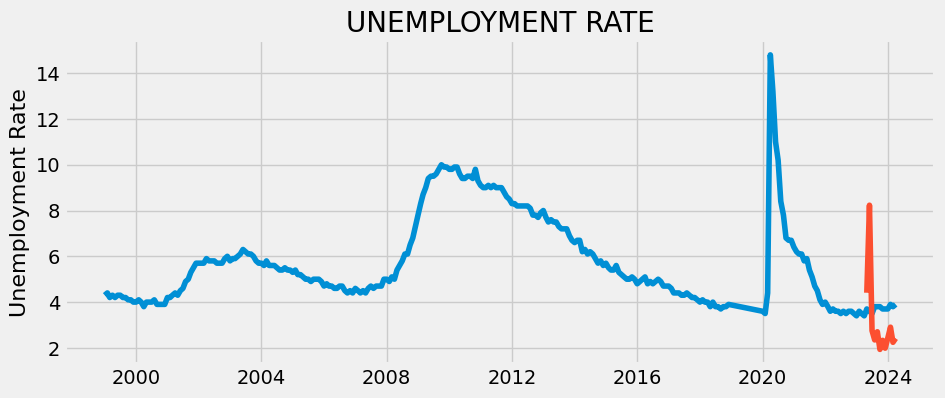

In [46]:
plt.figure(figsize=(10,4))
plt.plot(df_unemp)
plt.plot(pred)
plt.ylabel('Unemployment Rate', fontsize=16)
plt.title('UNEMPLOYMENT RATE', fontsize=20)

In [47]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['UNEMPLOYMENT RATE']*100)),4))

Mean Absolute Percent Error: 42.2939


In [48]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.8563650779543852


# Rolling Forecast Origin

In [49]:
rolling_predictions = test.copy()
pred_list = []
for train_end in test.index:
  train_data = df_unemp[:train_end-timedelta(days=1)]
  model = ExponentialSmoothing(train_data['UNEMPLOYMENT RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)
  pred = model.forecast()
  pred_list.append(pred.values)
print(pred)
prediction = pd.DataFrame(pred_list)

291    3.326596
dtype: float64


In [50]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [51]:
col2 = ['pred_var']
prediction.columns = col2
prediction.set_index(test.index,inplace=True)

In [52]:
rolling_residuals = test['UNEMPLOYMENT RATE'] - prediction['pred_var']

In [53]:
prediction.sort_values(by='date',inplace=True)

Text(0, 0.5, 'Error')

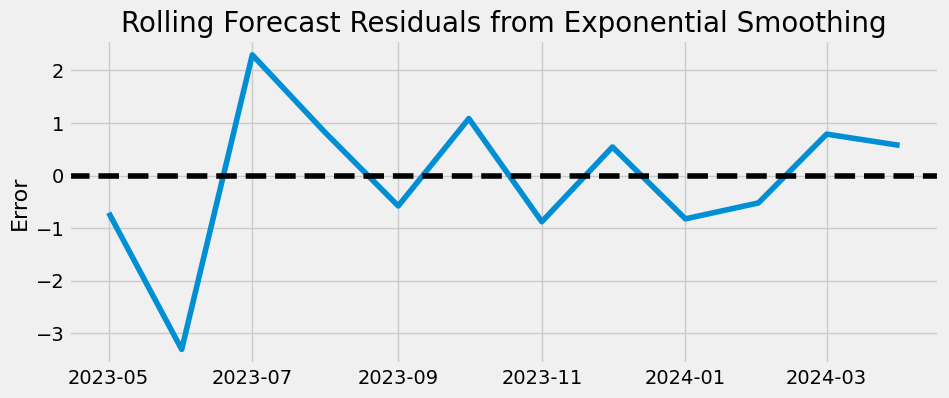

In [54]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [55]:
start_date = datetime(2023,4,1)
end_date = datetime(2024,3,1)

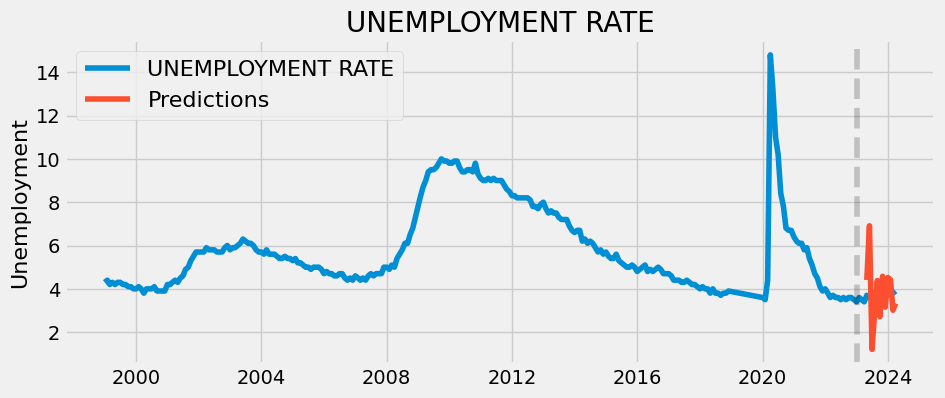

In [56]:
plt.figure(figsize=(10,4))

plt.plot(df_unemp)
plt.plot(prediction['pred_var'])
plt.legend(('UNEMPLOYMENT RATE', 'Predictions'), fontsize=16)
plt.title('UNEMPLOYMENT RATE', fontsize=20)
plt.ylabel('Unemployment', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [57]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test['UNEMPLOYMENT RATE']*100)),4))

Mean Absolute Percent Error: 29.2907


In [58]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.3500946751362715


# Forcasting the future

In [59]:
#Build an Exponential model with the best smoothing constant (0.5)
model2 = ExponentialSmoothing(df_unemp['UNEMPLOYMENT RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)

In [60]:
#Six (6) months future projection
future1 = pd.date_range('2024-02-01','2024-12-31', freq='MS')
col = ['UNEMPLOYMENT RATE']

In [61]:
df_unemp['UNEMPLOYMENT RATE'].tail()

date
2023-12-01    3.7
2024-01-01    3.7
2024-02-01    3.9
2024-03-01    3.8
2024-04-01    3.9
Name: UNEMPLOYMENT RATE, dtype: float64

In [62]:
predictions = model2.forecast(steps=11)
pred =  pd.DataFrame(predictions).set_index(future1)
pred.columns = col

In [63]:
pred

,UNEMPLOYMENT RATE
2024-02-01,5.218334
2024-03-01,6.025058
2024-04-01,10.903100
2024-05-01,4.085473
2024-06-01,3.216360
2024-07-01,3.695891
2024-08-01,2.580803
2024-09-01,3.178409
2024-10-01,2.717238
2024-11-01,3.485790


Text(0.5, 1.0, 'UNEMPLOYMENT RATE')

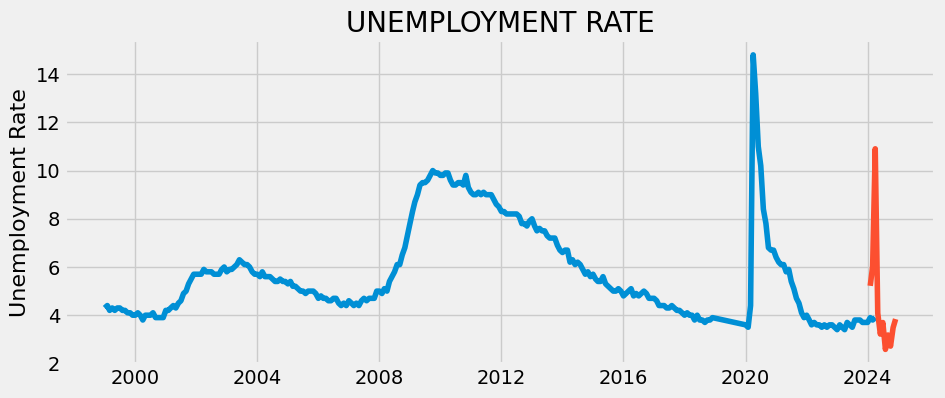

In [64]:
plt.figure(figsize=(10,4))
plt.plot(df_unemp)
plt.plot(pred)
plt.ylabel('Unemployment Rate', fontsize=16)
plt.title('UNEMPLOYMENT RATE', fontsize=20)